In [1]:
# The Visual Transformer Autoencoder did not work
# THis notebook runs a test to see if it can identify any patch, that is, any location, 
# or if it cannot distinguish the patches.

# I expect that this test will fail initially, and succeed once I have fixed the underlying issue

In [2]:
from visual_transformer import *

In [3]:
# There is no cuda:1 on the smaller penguins.farm
device = torch.device('cuda') #torch.device('cuda:1') # the big machine

In [4]:
brain = DefaultAgentBrain().to(device)

In [5]:
224 / 16

14.0

In [6]:
def get_batch(batchsize=4):
    res = torch.ones((batchsize, 3, 224, 224), device=device)
    res[:, :, :3*14, :3*14] = 0
    return res

In [7]:
# now for the real challenge: input has 1 black patch, output moves it to the right
import random

def get_moving_data(batchsize=4):
    res = torch.ones((batchsize, 3, 224, 224), device=device)
    out = torch.ones((batchsize, 3, 224, 224), device=device)
    for val in range(batchsize):
        x_patch = random.randint(0, 9)
        y_patch = random.randint(0, 12)
        res[val, :, y_patch*14:(y_patch+3)*14, x_patch*14:(x_patch + 3)*14] = 0
        out[val, :, y_patch*14:(y_patch+3)*14, (x_patch + 3)*14:(x_patch + 6)*14] = 0
    return res, out

In [8]:
import matplotlib.pyplot as plt

In [9]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

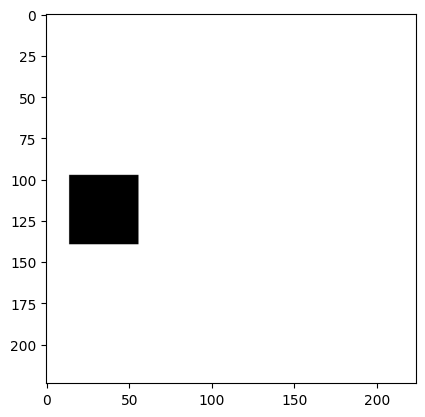

In [10]:
sample, out = get_moving_data()
quick_display(sample[3])

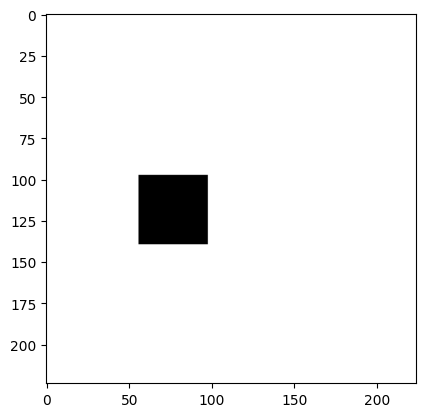

In [11]:
quick_display(out[3])

In [12]:
# now, will the brain learn to produce this image? Or merely splatter gray all over the canvas?

In [13]:
criterion = nn.MSELoss()

In [14]:
optimizer = optim.Adam(brain.parameters(), lr=0.0001, eps=1e-9) #0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
import time

total_batches = 6250*32

total_loss = 0
brain.train()

moving = False
for b in range(total_batches):
    if b == 0:
        start = time.time()
    #img_set = G.random_full_image_set(restrict_angles=True)
    #img_tensor = torch.permute(torch.FloatTensor(img_set).to(device), (0, 3, 1, 2))
    img_tensor, tgt_tensor = get_moving_data(4)
    batch_size = img_tensor.size()[0]
    #text_context = torch.randn((batch_size, 32, 768), device=device) # easier for pretraining to use randn
    recon = brain.img_autoencoder(img_tensor)#, text_context)
    if moving:
        loss = criterion(recon, tgt_tensor)
    else:
        loss = criterion(recon, tgt_tensor)#img_tensor)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()
    if b == 0:
        runtime = time.time() - start
        print(f"Time for 1 batch: {runtime} seconds")
    if (b % 100 == 99):
        avg_loss = total_loss / 100
        if avg_loss < 5e-3:
            moving = True
        total_loss = 0
        print(f"Avg loss for last 100 batches, at batch {b + 1}: {avg_loss}")
        torch.save(brain.img_enc.state_dict(), 'brain_checkpoints/img_encoder_weights_DEBUG_MOVING.pth')
        torch.save(brain.img_dec.state_dict(), 'brain_checkpoints/img_decoder_weights_DEBUG_MOVING.pth')

/home/atbolsh/anaconda3/envs/llava-florence/lib/python3.12/site-packages/torch/_tensor.py:955: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Time for 1 batch: 0.3418388366699219 seconds
Avg loss for last 100 batches, at batch 100: 0.11526150457561016
Avg loss for last 100 batches, at batch 200: 0.07692653179168701
Avg loss for last 100 batches, at batch 300: 0.06745049845427274
Avg loss for last 100 batches, at batch 400: 0.04654811196029186
Avg loss for last 100 batches, at batch 500: 0.037784572839736935
Avg loss for last 100 batches, at batch 600: 0.03587835066020489
Avg loss for last 100 batches, at batch 700: 0.03538745656609535
Avg loss for last 100 batches, at batch 800: 0.03404362784698606
Avg loss for last 100 batches, at batch 900: 0.024831097517162563
Avg loss for last 100 batches, at batch 1000: 0.014848838187754154
Avg loss for last 100 batches, at batch 1100: 0.011567788063548506
Avg loss for last 100 batches, at batch 1200: 0.009679372715763747
Avg loss for last 100 batches, at batch 1300: 0.009011143785901368
Avg loss for last 100 batches, at batch 1400: 0.009106672294437885
Avg loss for last 100 batches, at

In [ ]:
# Good start.
# Further work: check to make sure that what's being added is added correctly, in the right places, etc.

# Made sure it's correct? Switch to copying someone else's approach.

In [ ]:
quick_display(recon[0])

In [ ]:
mid = brain.img_enc.embed[0](img_tensor)

In [ ]:
torch.max(mid[0] - mid[0, 0])

In [ ]:
mid

In [ ]:
mid = brain.img_enc.embed[1](mid)

In [ ]:
mid

In [ ]:
mid.size()

In [ ]:
mid[0, 0]

In [ ]:
torch.max(mid[0, 128] - mid[0, 0])

In [ ]:
brain.img_enc.embed[1].pe